# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 1

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device

device(type='cuda')

# Prepare data

## Dataset

In [5]:
ds = 'WifiLocalization'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'Haibin',
                        'data_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([2000, 7]), torch.Size([2000]), 2000, 7, 4)

## Pseudo-electrical Signal

In [7]:
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.1562, 0.6207, 0.3636, 0.1667, 0.3396, 0.4167, 0.4857],
        [0.0938, 0.5862, 0.3636, 0.1818, 0.3396, 0.3333, 0.3714],
        [0.1719, 0.4828, 0.3939, 0.1515, 0.2453, 0.3333, 0.4000],
        [0.2031, 0.4828, 0.1515, 0.2273, 0.2264, 0.1944, 0.5143],
        [0.1719, 0.3103, 0.3939, 0.2121, 0.2264, 0.4444, 0.3143],
        [0.1562, 0.6552, 0.3030, 0.1667, 0.2453, 0.2500, 0.4286],
        [0.1406, 0.4483, 0.2424, 0.1515, 0.3774, 0.2778, 0.4000],
        [0.2031, 0.3793, 0.4545, 0.1667, 0.2830, 0.2778, 0.4571],
        [0.1406, 0.4828, 0.4242, 0.2121, 0.2453, 0.3056, 0.4571],
        [0.1875, 0.4828, 0.2121, 0.1364, 0.1698, 0.3056, 0.2000]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(4096, int(E*train_rate))
E_test = min(1024, int(E*test_rate))
E_valid = min(1024, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(1200, 400, 400)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 2
m = 0.3
T = 0.1
M_train = 100
K_train = 20
M_test = 20
K_test = 10

# Normal NN

## Define

In [12]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=7, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=4, bias=True)
  (3): Tanh()
)

## Training

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.2)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.46250 | Loss: 1.298303485
| Epoch:   500 | Accuracy: 0.97750 | Loss: 0.382109344
| Epoch:  1000 | Accuracy: 0.97750 | Loss: 0.379391491
| Epoch:  1500 | Accuracy: 0.97250 | Loss: 0.385902762
| Epoch:  2000 | Accuracy: 0.97500 | Loss: 0.382142097
| Epoch:  2500 | Accuracy: 0.97750 | Loss: 0.379388899
| Epoch:  3000 | Accuracy: 0.97750 | Loss: 0.379077226
| Epoch:  3500 | Accuracy: 0.97750 | Loss: 0.379533619
| Epoch:  4000 | Accuracy: 0.97250 | Loss: 0.378887266
| Epoch:  4500 | Accuracy: 0.97250 | Loss: 0.380263358
| Epoch:  5000 | Accuracy: 0.97750 | Loss: 0.379619032
| Epoch:  5500 | Accuracy: 0.97500 | Loss: 0.379103005
| Epoch:  6000 | Accuracy: 0.97750 | Loss: 0.381179541
| Epoch:  6500 | Accuracy: 0.97750 | Loss: 0.379095852
| Epoch:  7000 | Accuracy: 0.97750 | Loss: 0.378998190
| Epoch:  7500 | Accuracy: 0.97750 | Loss: 0.378817588
| Epoch:  8000 | Accuracy: 0.97250 | Loss: 0.378563166
| Epoch:  8500 | Accuracy: 0.97750 | Loss: 0.378852457
| Epoch:  

(4928, 0.37791478633880615)

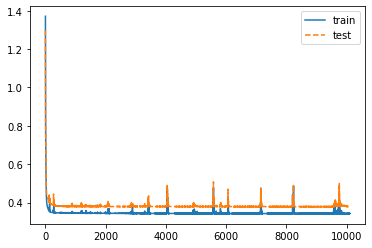

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [15]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.97500 | Loss: 0.380162209
| Epoch:   500 | Accuracy: 0.97500 | Loss: 0.378638148
| Epoch:  1000 | Accuracy: 0.97750 | Loss: 0.378512114
| Epoch:  1500 | Accuracy: 0.97750 | Loss: 0.378620982
| Epoch:  2000 | Accuracy: 0.97750 | Loss: 0.378745168
| Epoch:  2500 | Accuracy: 0.97750 | Loss: 0.378825605
| Epoch:  3000 | Accuracy: 0.97750 | Loss: 0.378941536
| Epoch:  3500 | Accuracy: 0.98000 | Loss: 0.378915340
| Epoch:  4000 | Accuracy: 0.98250 | Loss: 0.378523916
| Epoch:  4500 | Accuracy: 0.98250 | Loss: 0.377870113
| Epoch:  5000 | Accuracy: 0.98250 | Loss: 0.377676398
| Epoch:  5500 | Accuracy: 0.98250 | Loss: 0.377514750
| Epoch:  6000 | Accuracy: 0.98250 | Loss: 0.377389073
| Epoch:  6500 | Accuracy: 0.98250 | Loss: 0.377444237
| Epoch:  7000 | Accuracy: 0.98000 | Loss: 0.377461016
| Epoch:  7500 | Accuracy: 0.98000 | Loss: 0.377479434
| Epoch:  8000 | Accuracy: 0.98000 | Loss: 0.377499849
| Epoch:  8500 | Accuracy: 0.98000 | Loss: 0.377514750
| Epoch:  

(5801, 0.37579062581062317)

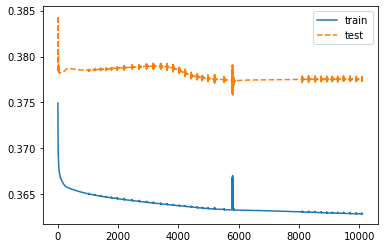

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [17]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.98000 | Loss: 0.375832945
| Epoch:   500 | Accuracy: 0.98250 | Loss: 0.377381355
| Epoch:  1000 | Accuracy: 0.98250 | Loss: 0.377396941
| Epoch:  1500 | Accuracy: 0.98250 | Loss: 0.377392471
| Epoch:  2000 | Accuracy: 0.98250 | Loss: 0.377381355
| Epoch:  2500 | Accuracy: 0.98250 | Loss: 0.377363324
| Epoch:  3000 | Accuracy: 0.98250 | Loss: 0.377339482
| Epoch:  3500 | Accuracy: 0.98250 | Loss: 0.377311587
| Epoch:  4000 | Accuracy: 0.98250 | Loss: 0.377281338
| Epoch:  4500 | Accuracy: 0.98250 | Loss: 0.377250701
| Epoch:  5000 | Accuracy: 0.98250 | Loss: 0.377221376
| Epoch:  5500 | Accuracy: 0.98250 | Loss: 0.377194822
| Epoch:  6000 | Accuracy: 0.98250 | Loss: 0.377176940
| Epoch:  6500 | Accuracy: 0.98250 | Loss: 0.377171546
| Epoch:  7000 | Accuracy: 0.98250 | Loss: 0.377176017
| Epoch:  7500 | Accuracy: 0.98250 | Loss: 0.377177775
| Epoch:  8000 | Accuracy: 0.98250 | Loss: 0.377177477
| Epoch:  8500 | Accuracy: 0.98250 | Loss: 0.377194166
| Epoch:  

(0, 0.3758329451084137)

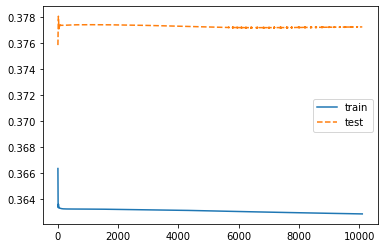

In [18]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [19]:
with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [20]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.975


In [21]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=7, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=4, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [22]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [23]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.23750 | Loss: 1.326425910 |
| Epoch:   500 | Accuracy: 0.97000 | Loss: 0.208951831 |
| Epoch:  1000 | Accuracy: 0.97000 | Loss: 0.219844222 |
| Epoch:  1500 | Accuracy: 0.97000 | Loss: 0.205982894 |
| Epoch:  2000 | Accuracy: 0.97250 | Loss: 0.210141599 |
| Epoch:  2500 | Accuracy: 0.98750 | Loss: 0.205328152 |
| Epoch:  3000 | Accuracy: 0.97000 | Loss: 0.209935531 |
| Epoch:  3500 | Accuracy: 0.97000 | Loss: 0.208308831 |
| Epoch:  4000 | Accuracy: 0.97000 | Loss: 0.208019316 |
| Epoch:  4500 | Accuracy: 0.97000 | Loss: 0.208584100 |
| Epoch:  5000 | Accuracy: 0.98000 | Loss: 0.217436612 |
| Epoch:  5500 | Accuracy: 0.97000 | Loss: 0.213566169 |
| Epoch:  6000 | Accuracy: 0.98250 | Loss: 0.204911873 |
| Epoch:  6500 | Accuracy: 0.98250 | Loss: 0.206921190 |
| Epoch:  7000 | Accuracy: 0.97000 | Loss: 0.210627049 |
| Epoch:  7500 | Accuracy: 0.97000 | Loss: 0.216532439 |
| Epoch:  8000 | Accuracy: 0.98000 | Loss: 0.208623081 |
| Epoch:  8500 | Accuracy: 0.97

(5810, 0.20386695861816406)

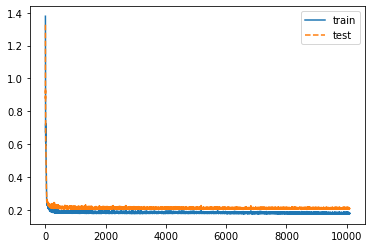

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [25]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.97000 | Loss: 0.206924438 |
| Epoch:   500 | Accuracy: 0.97250 | Loss: 0.204677001 |
| Epoch:  1000 | Accuracy: 0.97250 | Loss: 0.205682024 |
| Epoch:  1500 | Accuracy: 0.97500 | Loss: 0.204936057 |
| Epoch:  2000 | Accuracy: 0.97250 | Loss: 0.205209658 |
| Epoch:  2500 | Accuracy: 0.97250 | Loss: 0.205481187 |
| Epoch:  3000 | Accuracy: 0.97250 | Loss: 0.206247821 |
| Epoch:  3500 | Accuracy: 0.97250 | Loss: 0.205427438 |
| Epoch:  4000 | Accuracy: 0.97250 | Loss: 0.205094293 |
| Epoch:  4500 | Accuracy: 0.97250 | Loss: 0.205251530 |
| Epoch:  5000 | Accuracy: 0.97250 | Loss: 0.206108436 |
| Epoch:  5500 | Accuracy: 0.97500 | Loss: 0.205156088 |
| Epoch:  6000 | Accuracy: 0.97500 | Loss: 0.205811113 |
| Epoch:  6500 | Accuracy: 0.97250 | Loss: 0.205297008 |
| Epoch:  7000 | Accuracy: 0.97250 | Loss: 0.206368417 |
| Epoch:  7500 | Accuracy: 0.97250 | Loss: 0.206197634 |
| Epoch:  8000 | Accuracy: 0.97250 | Loss: 0.205458328 |
| Epoch:  8500 | Accuracy: 0.97

(5, 0.2041315734386444)

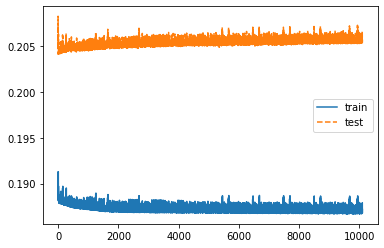

In [26]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [27]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.97250 | Loss: 0.204185441 |
| Epoch:   500 | Accuracy: 0.97250 | Loss: 0.204281271 |
| Epoch:  1000 | Accuracy: 0.97250 | Loss: 0.204341471 |
| Epoch:  1500 | Accuracy: 0.97250 | Loss: 0.204390019 |
| Epoch:  2000 | Accuracy: 0.97250 | Loss: 0.204493001 |
| Epoch:  2500 | Accuracy: 0.97250 | Loss: 0.204455450 |
| Epoch:  3000 | Accuracy: 0.97250 | Loss: 0.204558715 |
| Epoch:  3500 | Accuracy: 0.97250 | Loss: 0.204536468 |
| Epoch:  4000 | Accuracy: 0.97250 | Loss: 0.204579696 |
| Epoch:  4500 | Accuracy: 0.97250 | Loss: 0.204637498 |
| Epoch:  5000 | Accuracy: 0.97250 | Loss: 0.204554111 |
| Epoch:  5500 | Accuracy: 0.97250 | Loss: 0.204521596 |
| Epoch:  6000 | Accuracy: 0.97250 | Loss: 0.204499006 |
| Epoch:  6500 | Accuracy: 0.97250 | Loss: 0.204534397 |
| Epoch:  7000 | Accuracy: 0.97250 | Loss: 0.204584152 |
| Epoch:  7500 | Accuracy: 0.97250 | Loss: 0.204590335 |
| Epoch:  8000 | Accuracy: 0.97250 | Loss: 0.204567567 |
| Epoch:  8500 | Accuracy: 0.97

(1, 0.2040865272283554)

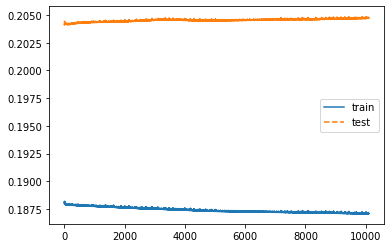

In [28]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [29]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [30]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Aging Aware PNN

In [31]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [32]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [33]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=500, cache=ds)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.25688 | Loss: 1.033678293 |
| Epoch:    25 | Accuracy: 0.49083 | Loss: 0.773498595 |
| Epoch:    50 | Accuracy: 0.62813 | Loss: 0.646800458 |
| Epoch:    75 | Accuracy: 0.69216 | Loss: 0.567477942 |
| Epoch:   100 | Accuracy: 0.72003 | Loss: 0.517080843 |
| Epoch:   125 | Accuracy: 0.77639 | Loss: 0.414907426 |
| Epoch:   150 | Accuracy: 0.79086 | Loss: 0.388902783 |
| Epoch:   175 | Accuracy: 0.79794 | Loss: 0.373234719 |
| Epoch:   200 | Accuracy: 0.80345 | Loss: 0.375531197 |
| Epoch:   225 | Accuracy: 0.80889 | Loss: 0.356876165 |
| Epoch:   250 | Accuracy: 0.79890 | Loss: 0.366350174 |
| Epoch:   275 | Accuracy: 0.80860 | Loss: 0.366127014 |
| Epoch:   300 | Accuracy: 0.81330 | Loss: 0.370106429 |
| Epoch:   325 | Accuracy: 0.81803 | Loss: 0.350006670 |
| Epoch:   350 | Accuracy: 0.80565 | Loss: 0.354871780 |
| Epoch:   375 | Accuracy: 0.81335 | Loss: 0.355575025 |
| Epoch:   400 | Accuracy: 0.81030 | Loss: 0.352274954 |
| Epoch:   425 | Accuracy: 0.81

(493, 0.3096097707748413)

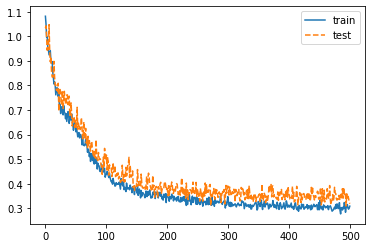

In [34]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [35]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=1000, cache=ds)

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.82425 | Loss: 0.331280679 |
| Epoch:    50 | Accuracy: 0.82920 | Loss: 0.329079241 |
| Epoch:   100 | Accuracy: 0.82913 | Loss: 0.332804382 |
| Epoch:   150 | Accuracy: 0.83341 | Loss: 0.311483622 |
| Epoch:   200 | Accuracy: 0.83315 | Loss: 0.333305866 |
| Epoch:   250 | Accuracy: 0.82115 | Loss: 0.341346622 |
| Epoch:   300 | Accuracy: 0.82331 | Loss: 0.324943155 |
| Epoch:   350 | Accuracy: 0.81498 | Loss: 0.356624514 |
| Epoch:   400 | Accuracy: 0.82506 | Loss: 0.345320165 |
| Epoch:   450 | Accuracy: 0.81179 | Loss: 0.350430906 |
| Epoch:   500 | Accuracy: 0.83024 | Loss: 0.318004578 |
| Epoch:   550 | Accuracy: 0.83593 | Loss: 0.328072846 |
| Epoch:   600 | Accuracy: 0.83811 | Loss: 0.309461147 |
| Epoch:   650 | Accuracy: 0.81966 | Loss: 0.354725629 |
| Epoch:   700 | Accuracy: 0.83157 | Loss: 0.312066406 |
| Epoch:   750 | Accuracy: 0.82769 | Loss: 0.329169661 |
| Epoch:   800 | Accuracy: 0.81825 | Loss: 0.340667427 |
| Epoch:   850 | Accuracy: 0.82

(187, 0.29484882950782776)

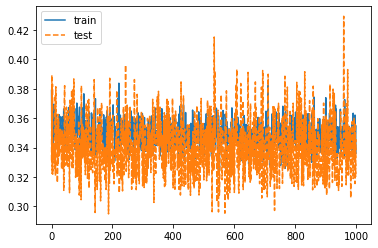

In [36]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [37]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=1000, cache=ds)

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.81798 | Loss: 0.350446641 |
| Epoch:    50 | Accuracy: 0.83160 | Loss: 0.329629749 |
| Epoch:   100 | Accuracy: 0.81958 | Loss: 0.333401680 |
| Epoch:   150 | Accuracy: 0.82956 | Loss: 0.325462162 |
| Epoch:   200 | Accuracy: 0.83011 | Loss: 0.312251061 |
| Epoch:   250 | Accuracy: 0.82198 | Loss: 0.352239341 |
| Epoch:   300 | Accuracy: 0.82200 | Loss: 0.341982812 |
| Epoch:   350 | Accuracy: 0.83203 | Loss: 0.318106353 |
| Epoch:   400 | Accuracy: 0.81324 | Loss: 0.355796814 |
| Epoch:   450 | Accuracy: 0.81971 | Loss: 0.344828635 |
| Epoch:   500 | Accuracy: 0.81091 | Loss: 0.349785239 |
| Epoch:   550 | Accuracy: 0.82156 | Loss: 0.342694402 |
| Epoch:   600 | Accuracy: 0.80842 | Loss: 0.370804131 |
| Epoch:   650 | Accuracy: 0.84180 | Loss: 0.308247268 |
| Epoch:   700 | Accuracy: 0.80442 | Loss: 0.373801798 |
| Epoch:   750 | Accuracy: 0.83260 | Loss: 0.314825535 |
| Epoch:   800 | Accuracy: 0.81410 | Loss: 0.361901939 |
| Epoch:   850 | Accuracy: 0.81

(412, 0.29570144414901733)

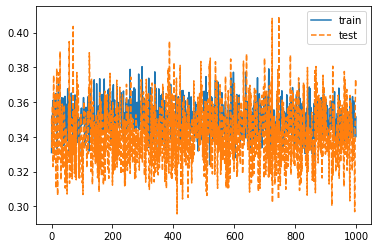

In [38]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [39]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)